# Vanilla implementation of VAE

This notebook is a vanilla implementation of VAE on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data compress it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

[AutoEncoder Structure](https://www.tensorflow.org/tutorials/generative/cvae)

[Loss functions and sampling](https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981)

In [1]:
import numpy as np
from tqdm import tqdm 
from IPython import display
from tensorflow import keras
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Load the MNIST dataset



In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_size = 60000
batch_size = 100
test_size = 10000
input_shape = (28, 28, 1)

In [6]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
train_images.shape

(60000, 28, 28, 1)

### Batch and shuffle the data with tf.data

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# Encoder and decoder networks

### Reparameterization trick

To generate a sample  for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation . However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate  using the decoder parameters and another parameter  as follows:

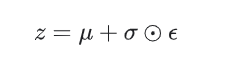

where  and  represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The  can be thought of as a random noise used to maintain stochasticity of . We generate  from a standard normal distribution.

The latent variable  is now generated by a function of ,  and , which would enable the model to backpropagate gradients in the encoder through  and  respectively, while maintaining stochasticity through .

In [ ]:
class VAE(tf.keras.Model):
    """Variational autoencoder."""

    def __init__(self, latent_dim, input_shape):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tfk.Sequential(
            [
                tfkl.InputLayer(input_shape=input_shape),
                tfkl.Flatten(),
                tfkl.Dense(300),
                # No activation
                tfkl.Dense(300)
            ]
        )

        self.decoder = tfk.Sequential(
            [
                tfkl.InputLayer(input_shape=(latent_dim,)),
                tfkl.Dense(300),
                # No activation
                tfkl.Dense(300),
            ]
        )

    @tf.function
    def sample(self, eps=None, N=100):
        if eps is None:
            eps = tf.random.normal(shape=(N, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.math.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        print(z.shape)
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


#### Define the loss function and the optimizer
we will be using a Bernoulli distributed MLP as decoder

In [ ]:
optimizer = tfk.optimizers.Adam(1e-4)

def normal_log_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.math.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# vae cost function as negative ELBO
def vae_cost(x_true, model, analytic_kl=True, kl_weight=1):
    # forward pass
    mean, logvar = model.encode(x_true)
    # z ~ q(z | x)
    z_sample = model.reparameterize(mean, logvar)
    x_recons_logits = model.decoder(z_sample)
    # compute cross entropy loss for each dimension of every datapoint
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true,
                        logits=x_recons_logits)  # shape=(batch_size, 28, 28, 1)
    # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    # compute reverse KL divergence, either analytically 
    # or through MC approximation with one sample
    if analytic_kl:
        kl_divergence = - 0.5 * tf.math.reduce_sum(
            1 + tf.math.log(tf.math.exp(logvar) - tf.math.square(mean) - tf.math.exp(logvar)),
            axis=1 #shape=(batch_size,)
        )
    else:
        logpz = normal_log_pdf(z_sample, 0., 0.)  # shape=(batch_size,)
        logqz_x = normal_log_pdf(z_sample, mean, logvar)  # shape=(batch_size,)
        kl_divergence = logqz_x - logpz
    elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
    return -elbo


@tf.function
def train_step(x_true, model, optimizer, analytic_kl=True, kl_weight=1):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        cost_mini_batch = vae_cost(x_true, model, analytic_kl, kl_weight)
    gradients = tape.gradient(cost_mini_batch, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim, input_shape)

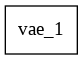

In [ ]:
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)

z.shape
logvar.shape

(16, 150)


ValueError: ignored

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('/content/drive/image_at_epoch/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [ ]:
test_sample.shape

TensorShape([16, 28, 28, 1])

In [ ]:
# generate_and_save_images(model, 0, test_sample)

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

# Generic Implementation

In [ ]:
# Uses (z_mean, z_log_var) to sample z, the vector encoding a digit. 
class Sample_Z(tfk.layers.Layer):
    def call(self, inputs):
        mu, rho = inputs
        sd = tf.math.log(1+tf.math.exp(rho))
        batch_size = tf.shape(mu)[0]
        dim_z = tf.shape(mu)[1]
        z_sample = mu + sd * tf.random.normal(shape=(batch_size, dim_z))
        return z_sample, sd
    

In [ ]:
# Maps MNIST digits to a triplet (z_sample, mu, sd).
class Encoder(tfkl.Layer):

    def __init__(self,
                 original_dim=(28,28,1),
                 latent_dim=40,
                 hidden_dim=300,
                 name='encoder',
                 **kwargs):
        
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.original_dim = original_dim

        self.dense_1 = tfkl.Dense(hidden_dim, activation='relu')
        self.dense_2 = tfkl.Dense(hidden_dim, activation='relu')
        self.dense_mean = tfkl.Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev  = tfkl.Dense(latent_dim, activation=None, name='z_raw_stddev')
        self.sampler_z = Sample_Z()

    def call(self, inputs):
        x = tfkl.Flatten()(tfkl.Input(shape=self.original_dim))
        x = self.dense_1(x)
        x = self.dense_2(x)
        mu = self.dense_mean(z)
        rho = self.dense_raw_stddev(z)
        z_sample, sd = self.sampler_z((mu,rho))
        return z_sample, mu, sd

# Converts z, the encoded digit vector, back into a readable digit
class Decoder(tfkl.Layer):
  
    def __init__(self,
                original_dim,
                hidden_dim=300,
                name='decoder',
                **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_1 = tfkl.Dense(hidden_dim, activation='relu')
        self.dense_2 = tfkl.Dense(hidden_dim, activation='relu')
        self.dense_output = tfkl.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.dense_output(x)


In [ ]:
# Combines the encoder and decoder into an end-to-end model for training.
class VAE(tf.keras.Model):

  def __init__(self,
               original_dim=(28,28,1),
               hidden_dim=300,
               latent_dim=40,
               learning_rate=0.01,
               kl_weight=1.0,
               name='autoencoder',
               **kwargs):
    super(VAE, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.learning_rate = learning_rate
    self.kl_weight = kl_weight
    self.encoder = Encoder(original_dim=original_dim,
                           latent_dim=latent_dim,
                           hidden_dim=hidden_dim)
    
    self.decoder = Decoder(original_dim=np.prod(original_dim),
                           hidden_dim=hidden_dim)

  def call(self, inputs):
    # self._set_inputs(inputs)
    z_sample, mu, sd = self.encoder(inputs)
    reconstructed = self.decoder(z_sample)
    # Add KL divergence regularization loss.
    kl_divergence = - 0.5 * tf.math.reduce_sum(1+tf.math.log(
          tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1)
    kl_divergence = tf.math.reduce_mean(kl_divergence)
    # self.add_loss(lambda: self.kl_weight * kl_divergence)
    self.add_loss(self.kl_weight * kl_divergence)
    return reconstructed

In [ ]:
# vae loss function -- only the negative log-likelihood part, 
# since we use add_loss for the KL divergence part
def partial_vae_loss(x_true, model):
    # x_recons_logits = model.encode_and_decode(x_true)
    x_recons_logits = model(x_true)
    # compute cross entropy loss for each dimension of every datapoint
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
      labels=x_true, logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood)

@tf.function
def train_step(x_true, model, optimizer, loss_metric):
    with tf.GradientTape() as tape:
        neg_log_lik = partial_vae_loss(x_true, model)
        # kl_loss = model.losses[-1]
        kl_loss = tf.math.reduce_sum(model.losses)  # vae.losses is a list
        total_vae_loss = neg_log_lik + kl_loss
    gradients = tape.gradient(total_vae_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_metric(total_vae_loss)

In [ ]:
# set hyperparameters
train_size = 60000
batch_size = 100
test_size = 10000
latent_dim=40
input_shape = (28, 28, 1)
lr = 0.0005
kl_w = 3
epochs = 2 #100
num_examples_to_generate = 16

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
# model training

vae = VAE(original_dim=input_shape, hidden_dim=300, latent_dim=40, learning_rate=lr, kl_weight=kl_w)
loss_metric = tf.keras.metrics.Mean()
opt = tfk.optimizers.Adam(vae.learning_rate)

In [ ]:
vae.compile(optimizer=opt, loss=loss_metric)

In [ ]:
for epoch in tqdm(range(epochs)):
    start_time = time.time()
    for train_x in tqdm(train_dataset):
        train_step(train_x, vae, opt, loss_metric)
    end_time = time.time()
    elbo = -loss_metric.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Train set ELBO: {}, time elapse for current epoch: {}'.format(
            epoch, elbo, end_time - start_time))
    # generate_images(vae, test_sample)

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: ignored

# TFP Implementation

In [10]:
def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                                      labels=x_true, 
                                                      logits=x_recons_logits)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    return tf.math.reduce_mean(neg_log_likelihood)

In [20]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*32, activation=None))
        layers.append(tfkl.Reshape((7,7,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten(name='x_params'))
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfpl.IndependentBernoulli(self.dim_x, name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [21]:
vae = VAE_MNIST(dim_z=40, kl_weight=3, learning_rate=0.0001)
vae = vae.build_vae_keras_model()

In [40]:
with tf.device('/device:GPU:0'):
    _ = vae.fit(x=train_images, y=train_images, batch_size=batch_size, epochs=15, 
                        verbose=1, validation_data=(test_images, test_images), shuffle=True)

Epoch 1/15
600/600 [==============================] - 3s 5ms/step - loss: 734.6484 - val_loss: 733.7518
Epoch 2/15
600/600 [==============================] - 3s 5ms/step - loss: 734.6756 - val_loss: 733.9080
Epoch 3/15
600/600 [==============================] - 3s 4ms/step - loss: 734.6505 - val_loss: 733.9348
Epoch 4/15
600/600 [==============================] - 3s 4ms/step - loss: 734.6254 - val_loss: 733.7123
Epoch 5/15
600/600 [==============================] - 3s 4ms/step - loss: 734.6671 - val_loss: 733.8529
Epoch 6/15
600/600 [==============================] - 3s 4ms/step - loss: 734.6390 - val_loss: 733.8990
Epoch 7/15
600/600 [==============================] - 3s 4ms/step - loss: 734.6572 - val_loss: 733.7903
Epoch 8/15
600/600 [==============================] - 3s 5ms/step - loss: 734.5837 - val_loss: 733.9161
Epoch 9/15
600/600 [==============================] - 3s 4ms/step - loss: 734.5579 - val_loss: 733.8290
Epoch 10/15
600/600 [==============================] - 3s 4ms/st

In [41]:
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Sequential)         multiple                  203216    
_________________________________________________________________
decoder (Sequential)         multiple                  101537    
Total params: 304,753
Trainable params: 304,753
Non-trainable params: 0
_________________________________________________________________
